In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt

## Loading our CTR Data fro AB Test

In [5]:
df = pd.read_csv("ab_test_click_data.csv")
print(df.head())
print("\n")
print(df.describe())
print("\n")
print(df.groupby("group").sum("click"))

   user_id  click group            timestamp
0        1      1   exp  2024-01-01 00:00:00
1        2      0   exp  2024-01-01 00:01:00
2        3      1   exp  2024-01-01 00:02:00
3        4      0   exp  2024-01-01 00:03:00
4        5      1   exp  2024-01-01 00:04:00


            user_id         click
count  20000.000000  20000.000000
mean   10000.500000      0.405250
std     5773.647028      0.490953
min        1.000000      0.000000
25%     5000.750000      0.000000
50%    10000.500000      0.000000
75%    15000.250000      1.000000
max    20000.000000      1.000000


         user_id  click
group                  
con    150005000   1989
exp     50005000   6116


#### A bar chart to showcase total clicks versus no click in each grouo can provide a clear visual comparison

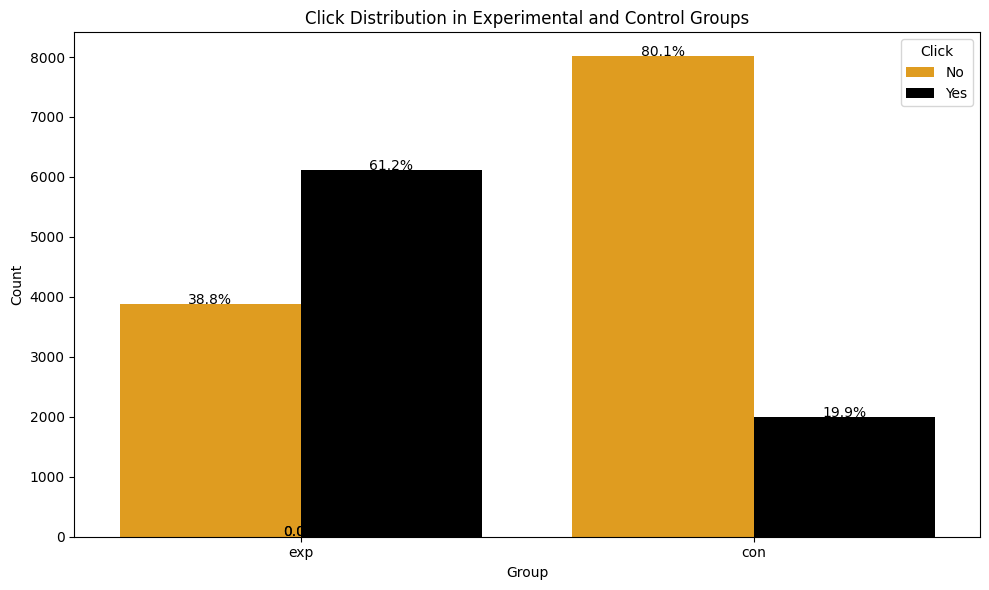

In [6]:
palette = {0:'orange', 1:'black'} #0 - no clicks, 1 - clicks

#Plot the bar graph
plt.figure(figsize = (10, 6))
ax = sns.countplot(x = "group", hue = "click", data=df, palette = palette)
plt.title('Click Distribution in Experimental and Control Groups')
plt.xlabel('Group')
plt.ylabel('Count')
plt.legend(title = 'Click', labels = ['No', 'Yes'])

#Calculate percentages and annotate the bars
group_counts = df.groupby(['group']).size()
group_click_counts = df.groupby(['group', 'click']).size().reset_index(name = 'count')

for p in ax.patches:
  height = p.get_height()
  group = 'exp' if p.get_x() < 0.5 else 'con'
  click = 1 if p.get_x() % 1 > 0.5 else 0
  total = group_counts.loc[group]
  percentage = 100*height/total
  ax.text(p.get_x() + p.get_width()/2., height + 5, f'{percentage:.1f}%', ha = "center", color = 'black', fontsize = 10)

plt.tight_layout()
plt.show()

### Parameters of the Model from Power Analysis

In [7]:
alpha = 0.05
print("Alpha: significance level is:", alpha)

delta = 0.1 #experimental 10% higher impact than control
print("Delta: minimum detectable effect is:", delta)

Alpha: significance level is: 0.05
Delta: minimum detectable effect is: 0.1


### Calculating total number of clicks per group by summing clicks

In [8]:
x_con = df.groupby("group")["click"].sum().loc["con"]
x_exp = df.groupby("group")["click"].sum().loc["exp"]

print(df.groupby("group")["click"].sum())
print("Number of Clicks in Control: ", x_con)
print("Number of Clicks in Experiment: ", x_exp)

group
con    1989
exp    6116
Name: click, dtype: int64
Number of Clicks in Control:  1989
Number of Clicks in Experiment:  6116


### Calculating Pooled Estimates for Click per Group

In [9]:
N_con = df[df["group"] == "con"].count()
N_exp = df[df["group"] == "exp"].count()

p_con_hat = x_con/N_con
p_exp_hat = x_exp/N_exp

print("Click Probability in Control Group: ", p_con_hat)
print("\n")
print("Click Probability in Experiment Group: ", p_exp_hat)
print("\n")

pooled_hat = (x_con + x_exp)/(N_con + N_exp)
print("Click Probability of Pooled Group: ", pooled_hat)

Click Probability in Control Group:  user_id      0.1989
click        0.1989
group        0.1989
timestamp       inf
dtype: float64


Click Probability in Experiment Group:  user_id      0.6116
click        0.6116
group        0.6116
timestamp    0.6116
dtype: float64


Click Probability of Pooled Group:  user_id      0.40525
click        0.40525
group        0.40525
timestamp    0.81050
dtype: float64


### Calculating Pooled Variance

In [10]:
pooled_variance = pooled_hat * (1 - pooled_hat) * (1/N_con + 1/N_exp)
print("p^_pooled is: ",pooled_hat)
print("pooled_variance is: ", pooled_variance)

p^_pooled is:  user_id      0.40525
click        0.40525
group        0.40525
timestamp    0.81050
dtype: float64
pooled_variance is:  user_id      0.000048
click        0.000048
group        0.000048
timestamp         inf
dtype: float64


### Calculating Standard Error and Test Statistics

In [17]:
#Computing the standard error of the test
SE = np.sqrt(pooled_variance)
print("Standard Error is: ", SE)

#Computing test statistic of Z-Test - z-test is used if the population variance is known, or if the sample size is larger than 30
Test_stat = (p_con_hat - p_exp_hat)/SE
print("Test Statistics for 2-sample Z-test is:", Test_stat)

#Critical value of Z-test
Z_crit = norm.ppf(1-alpha/2) #2 sided 2 sample test that is why divided by 2
print("Z-critical value from Standaed Normal Distribution: ", Z_crit)


Standard Error is:  user_id      0.006943
click        0.006943
group        0.006943
timestamp         inf
dtype: float64
Test Statistics for 2-sample Z-test is: user_id     -59.441633
click       -59.441633
group       -59.441633
timestamp          NaN
dtype: float64
Z-critical value from Standaed Normal Distribution:  1.959963984540054


### Calculating p_values of the Z-test
- A low value (p <= 0.05 at 5% significance) indicates strong evidence against null hypothesis, so we reject null hypothesis.
- A high value (p >= 0.05 at 5% significance) indicates weak evidence against null hypothesis, so we fail to reject null hypothesis.

In [20]:
#calculate p value
p_value = 2 * norm.sf(abs(Test_stat[0]))

def is_statistical_significance(p_value, alpha):
  print(f"P-value of 2-sample Z-test: {(p_value)}")

  #Determine Significance
  if p_value <= alpha:
    print("There is statistical significance, indicating that the observed differences between the groups are unlikely to have occurred. This suggests that the experiment group shows better result than the control group and we percieve a better click through rate.")
  else:
    print("There is statistical significance, suggesting that the observed differences between the groups could have occurred by random chance. This indicates that the experiment group doesn't shows better result than the control group.")

is_statistical_significance(p_value, alpha)

P-value of 2-sample Z-test: 0.0
There is statistical significance, indicating that the observed differences between the groups are unlikely to have occurred. This suggests that the experiment group shows better result than the control group and we percieve a better click through rate.


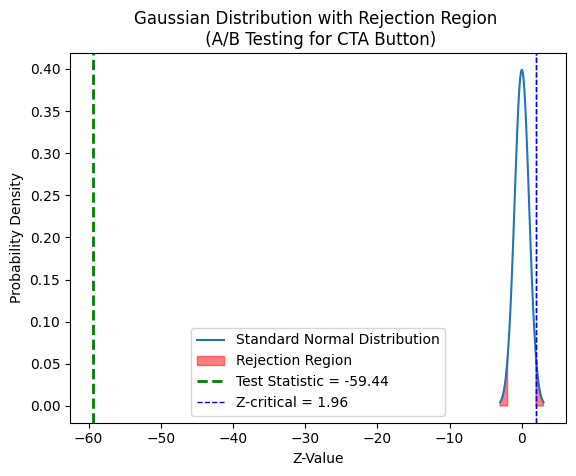

In [26]:
#Parameters
mu = 0
sigma = 1 #Standard Deviation
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = norm.pdf(x, mu, sigma)

#Plotting standard normal distribution
plt.plot(x, y, label = 'Standard Normal Distribution')
plt.fill_between(x, y, where=(x > Z_crit) | (x < -Z_crit), color = 'red', alpha = 0.5, label = 'Rejection Region')
# Adding Test Statistic
plt.axvline(Test_stat[0], color='green', linestyle='dashed', linewidth=2, label=f'Test Statistic = {Test_stat[0]:.2f}')
# Adding Z-Critical Values
plt.axvline(Z_crit, color = 'blue', linestyle = 'dashed', linewidth = 1, label = f'Z-critical = {Z_crit:.2f}')
plt.axvline(Z_crit, color = 'blue', linestyle = 'dashed', linewidth = 1)

#Adding labels and title
plt.xlabel('Z-Value')
plt.ylabel('Probability Density')
plt.title('Gaussian Distribution with Rejection Region \n (A/B Testing for CTA Button)')
plt.legend()
plt.show()

### Calculating Confidence Interval of the Test

In [27]:
CI = [
    round((p_exp_hat - p_con_hat) - SE*Z_crit, 3), #Lower Bound of CI
    round((p_exp_hat - p_con_hat) + SE*Z_crit, 3)  #Upper Bound of CI
]

print("Confidence Interval of the 2 sample Z-test is: ", CI)

Confidence Interval of the 2 sample Z-test is:  [user_id      0.399
click        0.399
group        0.399
timestamp     -inf
dtype: float64, user_id      0.426
click        0.426
group        0.426
timestamp      NaN
dtype: float64]


### Testing for Practical Significance in A/B Testing

In [37]:
def is_practical_significance(delta, CI):
  lower_bound_CI = CI[0]

  if lower_bound_CI >= delta:
    print(f"We have practical significance! \nWith MDE of {delta}, The difference between the Control and Experiment group is practically significant")
    return True
  else:
    print(f"We don't have practical significance!, The difference between the Control and Experiment group is not practically significant")
    return False

significance = is_practical_significance(delta, CI[0])
print("Lower bound of 95% confidence internval is: ",CI[0])

We have practical significance! 
With MDE of 0.1, The difference between the Control and Experiment group is practically significant
Lower bound of 95% confidence internval is:  user_id      0.399
click        0.399
group        0.399
timestamp     -inf
dtype: float64
